# Is ChatGPT a scientist?
##### By Sergi González-Herrero

## Context
This Jupyther notebook attempts to test ChatGPT's ability to perform scientific research. To do so, I asked ChatGPT the scientific question from one of my last published researchs to compare with it and to see if it can produce some (probably more simplified) python code that make some sense and can be applied to the climate sciences. The research to reproduce was Gonzalez-Herrero et al. 2022 entitled “Climate warming amplified the 2020 record-breaking heatwave in the Antarctic Peninsula” (https://www.nature.com/articles/s43247-022-00450-5) which was developed using almost exclusively python code.

## Question
Write a python code which enables me to  attribute a heatwave event in antarctica to climate change. 

## Answer
Attributing a single weather event to climate change can be a complex and nuanced task that requires careful statistical analysis and consideration of a variety of factors. However, here is a basic Python code that uses temperature data from Antarctica to demonstrate how to compare the frequency and intensity of heatwaves in recent years to historical data, which could help suggest whether there has been a change in the climate:

_[the code was inserted here]_

This code reads in temperature data from a file (which should include columns for the year, maximum temperature, and minimum temperature), calculates the daily mean temperature, and defines a heatwave as three or more consecutive days with a mean temperature above the 90th percentile of historical data (calculated over a rolling window of 30 days). It then counts the number of heatwaves in recent years (defined here as years 2010 and later), calculates the average number of heatwaves per year in the historical record (defined here as years before 2010), and plots the temperature data and the 90th percentile threshold. Finally, it prints the number of heatwaves in recent years and the historical average.

This code is meant as a starting point for analyzing temperature data and does not constitute a rigorous statistical analysis. Other factors, such as changes in atmospheric circulation patterns or other climate variables, should also be considered when attributing a single weather event to climate change.

## Methodology
Since ChatGPT does not provide the data, I produced some extra code to download the data in cell #2 and to prepare the data in the format described in cell #3 (notice that I needed to make asumptions that ChatGPT did not fully consider). In cell #4 the chatGPT code is applied without any modifications and I show the output in cell #5. Some conclusions are drawn in cell #6.

In [1]:
##########################
# Download Dataset
##########################

import cdsapi
c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'variable': '2m_temperature',
        'year': [
            '1980', '1981',
            '1982', '1983', '1984',
            '1985', '1986', '1987',
            '1988', '1989', '1990',
            '1991', '1992', '1993',
            '1994', '1995', '1996',
            '1997', '1998', '1999',
            '2000', '2001', '2002',
            '2003', '2004', '2005',
            '2006', '2007', '2008',
            '2009', '2010', '2011',
            '2012', '2013', '2014',
            '2015', '2016', '2017',
            '2018', '2019', '2020',
        ],
        'month': ['01','02','03','04','05','06','07','08','09','10','11','12'],
        'day': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
            '13', '14', '15',
            '16', '17', '18',
            '19', '20', '21',
            '22', '23', '24',
            '25', '26', '27',
            '28', '29', '30',
            '31',
        ],
        'time': [
            '00:00',
            '03:00',
            '06:00',
            '09:00',
            '12:00',
            '15:00',
            '18:00',
            '21:00',
        ],
        'area': [-62, -76, -70, -55],
        'format': 'netcdf',
    },
    'Antarctica_temps_chatGPT_pre.nc')

2023-02-18 17:45:02,299 INFO Welcome to the CDS
2023-02-18 17:45:02,302 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-02-18 17:45:02,488 INFO Request is completed
2023-02-18 17:45:02,489 INFO Downloading https://download-0014-clone.copernicus-climate.eu/cache-compute-0014/cache/data1/adaptor.mars.internal-1676729604.3617115-12114-2-418580f0-6194-4ecc-ae43-d24845088686.nc to Antarctica_temps_chatGPT_pre.nc (641.4M)
2023-02-18 17:50:51,935 INFO Download rate 1.8M/s                                                                      


Result(content_length=672603656,content_type=application/x-netcdf,location=https://download-0014-clone.copernicus-climate.eu/cache-compute-0014/cache/data1/adaptor.mars.internal-1676729604.3617115-12114-2-418580f0-6194-4ecc-ae43-d24845088686.nc)

In [3]:
##########################
# File preparation
##########################
import netCDF4
import numpy as np
import pandas as pd

# NOTE: Although chatGPT does not specify the timestep needed and only specifies that 
# the file "should include columns for the year, maximum temperature, and minimum temperature"
# I assumed that daily timestep is necessary according the code.
# Therefore it is retreived the maximum and minimum temperature, as well as the year for every
# day since 1980, using the average temperature for the AP region [62–70°S 76–55°W]

#Load netcdf
filename_sfc_T = 'Antarctica_temps_chatGPT_pre.nc'
ncdf_T = netCDF4.Dataset(filename_sfc_T)

#Get dimensions
lons = ncdf_T.variables['longitude'][:]
lats = ncdf_T.variables['latitude'][:]
times = ncdf_T.variables['time'][:]

#Calculate datetime
dtimes = np.empty(len(times), dtype='datetime64[h]')
for i,t in enumerate(times):
    dtimes[i] = np.datetime64('1900-01-01') + np.timedelta64(np.int64(t),'h')
dtimes = dtimes.astype('datetime64')

#Get variables
t2m = ncdf_T.variables['t2m'][:,:,:]-273.15

#Average regionly for every timestep 
#(notice that as a test I did not averaged weighting for the latitude)
t2m_m = np.mean(t2m, axis=(1, 2))

#Average daily and get max and min
dtimes_24H = np.empty(int(np.size(dtimes)/8), dtype='datetime64[D]')
t2m_24H = np.empty(int(np.size(t2m_m)/8))
t2m_max_24H = np.empty(int(np.size(t2m_m)/8))
t2m_min_24H = np.empty(int(np.size(t2m_m)/8))
for i in range(np.size(dtimes_24H)):
    #print(i)
    dtimes_24H[i] = dtimes[i*8]
    t2m_24H[i] = np.mean(t2m_m[i*8:i*8+8], axis=0)
    t2m_max_24H[i] = np.max(t2m_m[i*8:i*8+8], axis=0)
    t2m_min_24H[i] = np.min(t2m_m[i*8:i*8+8], axis=0)
    

#Add year column
#year = dtimes_24H.astype('M8[Y]')
year = pd.to_datetime(dtimes_24H).year
    
#Make pandas dataframe and save file
d = {'Year':year, 'Mean_temp': t2m_24H, 'Max_temp': t2m_max_24H, 'Min_temp':t2m_min_24H}
df = pd.DataFrame(data=d, index=dtimes_24H)
df.to_csv('antarctica_temps.csv')

df

,Year,Mean_temp,Max_temp,Min_temp
1980-01-01,1980,0.826676,1.528784,0.049164
1980-01-02,1980,0.709341,1.241750,0.169317
1980-01-03,1980,0.416573,1.421200,-0.596175
1980-01-04,1980,0.226038,1.131728,-0.823217
1980-01-05,1980,0.170212,0.874206,-0.693908
...,...,...,...,...
2020-12-27,2020,0.064490,0.764760,-0.795709
2020-12-28,2020,0.286356,1.201335,-0.631037
2020-12-29,2020,-0.092749,0.529263,-0.875585
2020-12-30,2020,-0.519700,0.464520,-1.658491


Number of heatwaves in recent years: 171
Historical average number of heatwaves per year: 15.733333333333333


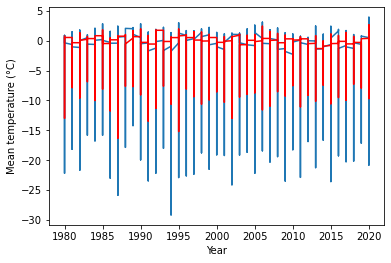

In [4]:
##########################
# Chat GPT Code
##########################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load temperature data from a file
temp_data = pd.read_csv('antarctica_temps.csv')

# Calculate the daily mean temperature
temp_data['Mean_temp'] = (temp_data['Max_temp'] + temp_data['Min_temp']) / 2

# Define a heatwave as three or more consecutive days with a mean temperature above the 90th percentile of historical data
temp_data['90th_percentile'] = temp_data['Mean_temp'].rolling(window=30).quantile(0.9, interpolation='linear')
temp_data['Heatwave'] = (temp_data['Mean_temp'] > temp_data['90th_percentile']).rolling(window=3).sum() >= 3

# Count the number of heatwaves in recent years
recent_heatwaves = temp_data.loc[temp_data['Year'] >= 2010, 'Heatwave'].sum()

# Calculate the average number of heatwaves per year in the historical record
historical_heatwaves = temp_data.loc[temp_data['Year'] < 2010, 'Heatwave'].sum() / (2010 - temp_data['Year'].min())

# Plot the temperature data and the 90th percentile threshold
plt.plot(temp_data['Year'], temp_data['Mean_temp'])
plt.plot(temp_data['Year'], temp_data['90th_percentile'], 'r')
plt.xlabel('Year')
plt.ylabel('Mean temperature (°C)')

# Print the number of heatwaves in recent years and the historical average
print(f'Number of heatwaves in recent years: {recent_heatwaves}')
print(f'Historical average number of heatwaves per year: {historical_heatwaves}')

In [14]:
##########################
# Chat GPT temp_data dataframe
##########################
temp_data

,Unnamed: 0,Year,Mean_temp,Max_temp,Min_temp,90th_percentile,Heatwave
0,1980-01-01,1980,0.788974,1.528784,0.049164,NaN,False
1,1980-01-02,1980,0.705533,1.241750,0.169317,NaN,False
2,1980-01-03,1980,0.412513,1.421200,-0.596175,NaN,False
3,1980-01-04,1980,0.154256,1.131728,-0.823217,NaN,False
4,1980-01-05,1980,0.090149,0.874206,-0.693908,NaN,False
...,...,...,...,...,...,...,...
14971,2020-12-27,2020,-0.015474,0.764760,-0.795709,0.183528,False
14972,2020-12-28,2020,0.285149,1.201335,-0.631037,0.218090,False
14973,2020-12-29,2020,-0.173161,0.529263,-0.875585,0.218090,False
14974,2020-12-30,2020,-0.596986,0.464520,-1.658491,0.218090,False


## Conclusions
After asking ChatGPT to produce code that mimics my research, I conclude that ChatGPT can make perfectly working pyhton code. However, what at first glance appeared to be promising code, turned out to be code with numerous flaws. 

Here are the major flaws:

- The main flaw occurs with the heatwave definition. There is not a common definition of a heatwave, and different national services and international organisms present different definitions. ChatGPT defines a heatwave _"as three or more consecutive days with a mean temperature above the 90th percentile of historical data (calculated over a rolling window of 30 days)"_ which is similar to the Heat and Cold Wave Index (HCWI) used by Copernicus (Lavaysse et al. 2018). So far so good. The mistake that ChatGPT commits is to understand that the rolling window must be carried out on the current date and not on the calendar day during all the reference period (that is, if we take the temperature on 15th March 2023, we must compare with a rolling window between all the 1st-30th Marchs defined in the climatology (usually 30 years). Instead, ChatGPT only takes as a period of reference the 1st-30th March 2023. Therefore, using this definition in a oscillating climate we will always have on average at least one heatwave a month and does not matter if the temperature increases or not. 


- The second main flaw is in the plot. ChatGPT is thinking in one hand that the file has a timestep of days (to calculate the number of heatwaves), but on the plot is thinking that the file has a timestep of years. It wants to make a plot with one data point per year, but the result is a mess. It seems that it has some internal confusion about the original data file and how to apply it in different analysis. It probably made up the code with AI trained using different analysis which do not have an internal coherence. 

Some other minor issues:
- The code uses predefined parameters and does not take into account common sense options such as center the rolling average (by default is center=False and set the window labels as the right edge of the window index).


- It is strange that the outputs are on one hand the total number of heatwaves since 2010 and on the other the average per year before 2010, which are not comparable results. As a curiosity, the average number of heatwaves (as defined by ChatGPT) between 2010 and 2020 is 15.54, below the period prior to 2010. 

Notice that ChatGPT states that _"This code is meant as a starting point for analyzing temperature data and does not constitute a rigorous statistical analysis."_ We have seen that the code is not a starting point, but I like to see this disclaimer in the answer. Indeed, after pressing it with related questions such as _"Can you refine the code to be able to attribute the 6-7 February 2020 heatwave event to climate change?" or "And can you do this analyisis more robust?"_, ChatGPT presented some other analyisis, sometimes simpler, and always with disclaimers like: _"Please note that this code provides a simplified example of a more robust analysis and should not be used for any official or scientific purpose."_

The main conclusion of this test is: **ChatGPT is not a scientist and you better not risk asking him to do your research for you**


## Supplementary material
After the test we told ChatGPT the following sentence "The code you wrote is wrong, it works but it has some conceptual flaws. Please, write a critical essay about your flaws when generating code for climate research". The answer was:

------------

As an artificial intelligence language model, I am designed to generate code for a wide range of tasks, including climate research. However, like any tool or technology, there are limitations and potential flaws that must be considered when relying on machine-generated code for scientific analysis.

One potential flaw is the risk of overfitting or bias in the code. Machine learning algorithms rely on patterns in data to make predictions or generate code, and if the training data is not representative of the larger population or if the model is too complex, it can lead to overfitting, where the model memorizes the training data instead of learning generalizable patterns. This can lead to inaccurate or biased results, especially in complex fields like climate research where the data is noisy and there are many confounding factors to consider.

Another potential flaw is the lack of human judgment and expertise in the code generation process. While machine learning algorithms can identify patterns and correlations in data, they are not capable of understanding the underlying physical processes or scientific theories that govern climate systems. Without human oversight and input, machine-generated code may miss important nuances or oversimplify complex phenomena, leading to incorrect or incomplete conclusions.

Furthermore, machine-generated code is only as good as the data it is trained on. Climate data is notoriously complex, with many sources of error and uncertainty, and may require significant preprocessing and cleaning before it can be used for analysis. If the data is incomplete or inaccurate, the machine-generated code will be similarly flawed, potentially leading to incorrect or misleading results.

In addition, machine-generated code may not be transparent or explainable, making it difficult for researchers to understand how the code arrived at its conclusions. In the case of climate research, where policy decisions and public opinion can be influenced by scientific findings, it is important to have a clear understanding of how the analysis was conducted and what assumptions were made.

Despite these potential flaws, machine-generated code can be a powerful tool for climate research, especially when used in conjunction with human expertise and judgment. By automating repetitive or time-consuming tasks, machine learning algorithms can free up researchers to focus on more complex or creative aspects of the analysis. However, it is important to approach machine-generated code with a critical eye, understanding its limitations and potential biases, and validating its results against independent sources of data and expert judgment. Only by combining the strengths of machine learning with the insights and expertise of human researchers can we hope to make meaningful progress in understanding and addressing the complex challenges of climate change.

#### References

González-Herrero, S., Barriopedro, D., Trigo, R.M. et al. Climate warming amplified the 2020 record-breaking heatwave in the Antarctic Peninsula. Commun Earth Environ 3, 122 (2022). https://doi.org/10.1038/s43247-022-00450-5

Lavaysse, C., C. Cammalleri, A. Dosio, G. van der Schrier, A. Toreti, and J. Vogt. 2018. Towards a
monitoring system of temperature extremes in Europe. Natural Hazards and Earth System
Sciences, 18, 91-104. https://doi.org/10.5194/nhess-18-91-2018

#### Acknowledgments
Like many of these stories, the conceptualization of this research began in a bar discussion among colleagues. I want to thank all the folks who participated in that discussion and gave me the idea to run this test: Beppi, Chiara, Tiziano, Sophia, Rosa, Vincent and especially Mathias who pushed to test the capabilities of ChatGPT. The beers that made possible this research were funded by ourselves.